In [84]:
#import packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

In [85]:
# Load data
data = pd.read_csv('../data/qbs.csv')
team_records = pd.read_csv('../data/team_records.csv')

# Rename player_teamName to team
data = data.rename(columns={'player_teamName': 'team'})

# Drop rows where season = 2024
data = data[data['season'] != 2024]

# Preprocess team_records, drop rows where season = 2024 and remove _id column
team_records = team_records[team_records['season'] != 2024]
team_records = team_records.drop(columns=['_id'])

# Add win_rate column to team_records
team_records['win_rate'] = team_records['wins'] / (team_records['wins'] + team_records['losses'])

#if win_rate cell is null replace with -999
team_records['win_rate'] = team_records['win_rate'].fillna(-999)

# Add win rate to data where team = team
data = pd.merge(data, team_records[['team', 'season', 'win_rate']], on=['team', 'season'], how='left')

data_copy = data.copy()

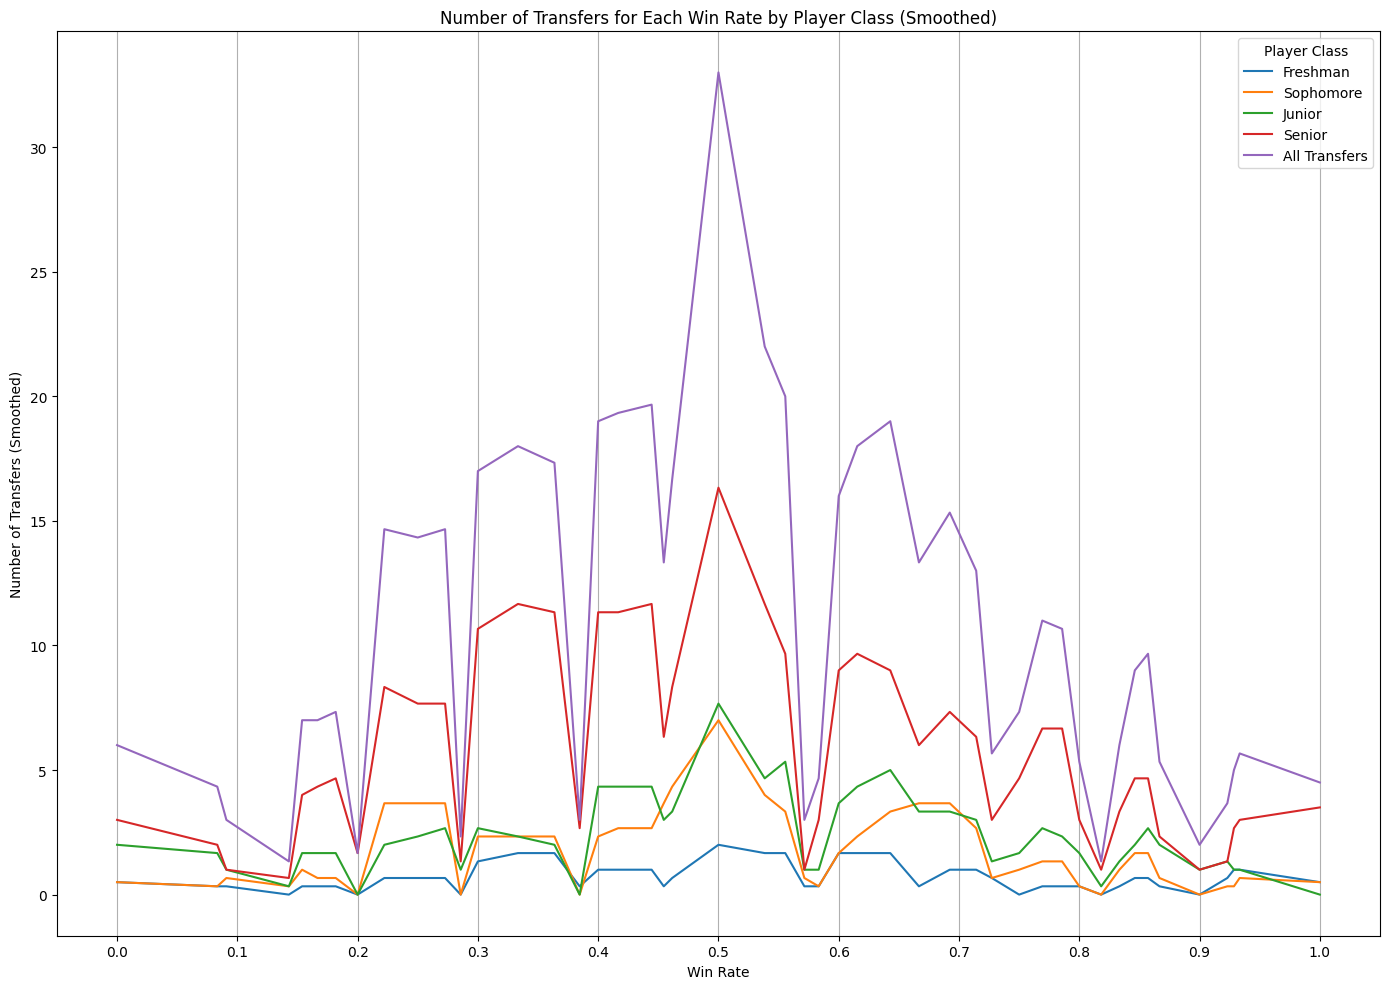

In [86]:
# Visualize correlation between transfer rates and team performance/records
data_transfer = data[data['transfer'] == 1]
data_transfer = data_transfer[data_transfer['player_class'].isin([1, 2, 3, 4])]

# Group by win_rate and player_class, count transfers
class_transfer_counts = data_transfer.groupby(['win_rate', 'player_class']).size().unstack(fill_value=0)
class_transfer_counts.columns = ['Freshman', 'Sophomore', 'Junior', 'Senior']

# Add total transfers column
class_transfer_counts['All Transfers'] = class_transfer_counts.sum(axis=1)

# Reset index to make win_rate a column
class_transfer_counts = class_transfer_counts.reset_index()

# Sort by win_rate
class_transfer_counts = class_transfer_counts.sort_values('win_rate')

# Apply smoothing
window_size = 3
for col in class_transfer_counts.columns[1:]:  # Skip 'win_rate' column
    class_transfer_counts[col] = class_transfer_counts[col].rolling(window=window_size, center=True, min_periods=1).mean()

# Plot
plt.figure(figsize=(14, 10))

# Plot lines for each player class and total transfers
for column in ['Freshman', 'Sophomore', 'Junior', 'Senior', 'All Transfers']:
    sns.lineplot(x='win_rate', y=column, data=class_transfer_counts, label=column)

plt.title('Number of Transfers for Each Win Rate by Player Class (Smoothed)')
plt.xlabel('Win Rate')
plt.ylabel('Number of Transfers (Smoothed)')
plt.legend(title='Player Class')
plt.grid(axis='x')
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()

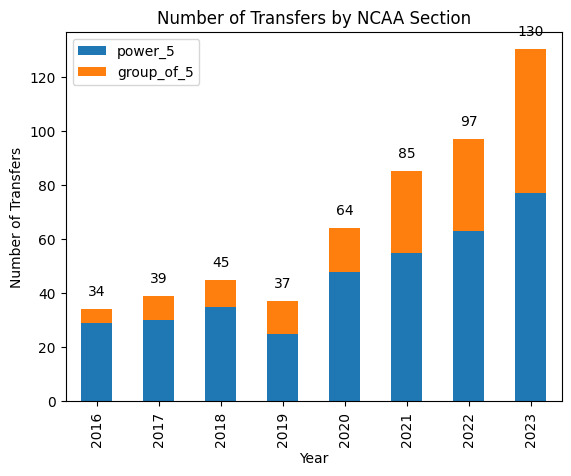

In [87]:
# Visualize the difference between power 5 and group of 5 schools
power_5 = ['SEC', 'ACC', 'Big 12', 'Big Ten', 'Pac-12']

# Add the new 'is_power_5' column
data_copy['is_power_5'] = data_copy['team_conference'].isin(power_5).astype(int)

power_5_mask = data_copy['is_power_5'] == 1
power_5_transfers = data_copy[power_5_mask & (data_copy['transfer'] == 1)]
group_of_5_transfers = data_copy[~power_5_mask & (data_copy['transfer'] == 1)]

transfer_stats = {}

for year in range(2016, 2024):
    power_5_transfers_year = power_5_transfers[power_5_transfers['season'] == year]
    group_of_5_transfers_year = group_of_5_transfers[group_of_5_transfers['season'] == year]
    transfer_stats[year] = {
        'power_5': len(power_5_transfers_year),
        'group_of_5': len(group_of_5_transfers_year)
    }

transfer_stats_df = pd.DataFrame(transfer_stats).T

# Plot the data
ax = transfer_stats_df.plot(kind='bar', stacked=True)
plt.title('Number of Transfers by NCAA Section')
plt.xlabel('Year')
plt.ylabel('Number of Transfers')

totals = transfer_stats_df.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total + 5, str(total), ha='center')

plt.show()

## Compute Win Rate / Class Risk Factor
Add a factor for the win rate and class risk factor
Theoretically the seniors around a 0.5 win rate should have the highest risk factor

In [88]:
# Compute Win Rate / Class Risk Factor
class_risk_factors = {
    1: 0.0542,
    2: 0.1006,
    3: 0.0932,
    4: 0.1307
}

# Start with a copy of data_copy
risk_factor_data = data_copy.copy()

# Remove columns that contain _stats or _usage in the column name
risk_factor_data = risk_factor_data.drop(columns=[col for col in risk_factor_data.columns if 'stats_' in col or 'usage_' in col])

# Add class risk factor to data for all players (not just transfers)
risk_factor_data['class_risk_factor'] = risk_factor_data['player_class'].map(class_risk_factors)

# Fill NaN values in class_risk_factor (for player classes not in our dictionary) with 0
risk_factor_data['class_risk_factor'] = risk_factor_data['class_risk_factor'].fillna(0)

# Add win_rate_class_risk_factor column
risk_factor_data['win_rate_class_risk_factor'] = risk_factor_data['win_rate'] * risk_factor_data['class_risk_factor']

# Fill NaN values in win_rate_class_risk_factor with -999
risk_factor_data['win_rate_class_risk_factor'] = risk_factor_data['win_rate_class_risk_factor'].fillna(-999)

# Keep only relevant columns
risk_factor_data = risk_factor_data[['player_playerId', 'season', 'team', 'win_rate', 'class_risk_factor', 'win_rate_class_risk_factor']]

# Merge risk_factor_data with data_copy
data_copy = pd.merge(data_copy, risk_factor_data, on=['player_playerId', 'season', 'team', 'win_rate'], how='left')

# Print some statistics to verify
print("Number of rows in data_copy:", len(data_copy))
print("Number of non-null class_risk_factor:", data_copy['class_risk_factor'].count())
print("Number of non-null win_rate_class_risk_factor:", data_copy['win_rate_class_risk_factor'].count())
print("Number of -999 values in win_rate_class_risk_factor:", (data_copy['win_rate_class_risk_factor'] == -999).sum())

Number of rows in data_copy: 5493
Number of non-null class_risk_factor: 5493
Number of non-null win_rate_class_risk_factor: 5493
Number of -999 values in win_rate_class_risk_factor: 0


C:\Users\aj132\AppData\Local\Temp\ipykernel_3116\455938342.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='win_rate_class_risk_factor', y='win_rate_class_risk_factor', data=smoothed_risk_factor_data, estimator=lambda x: len(x), ci=None)


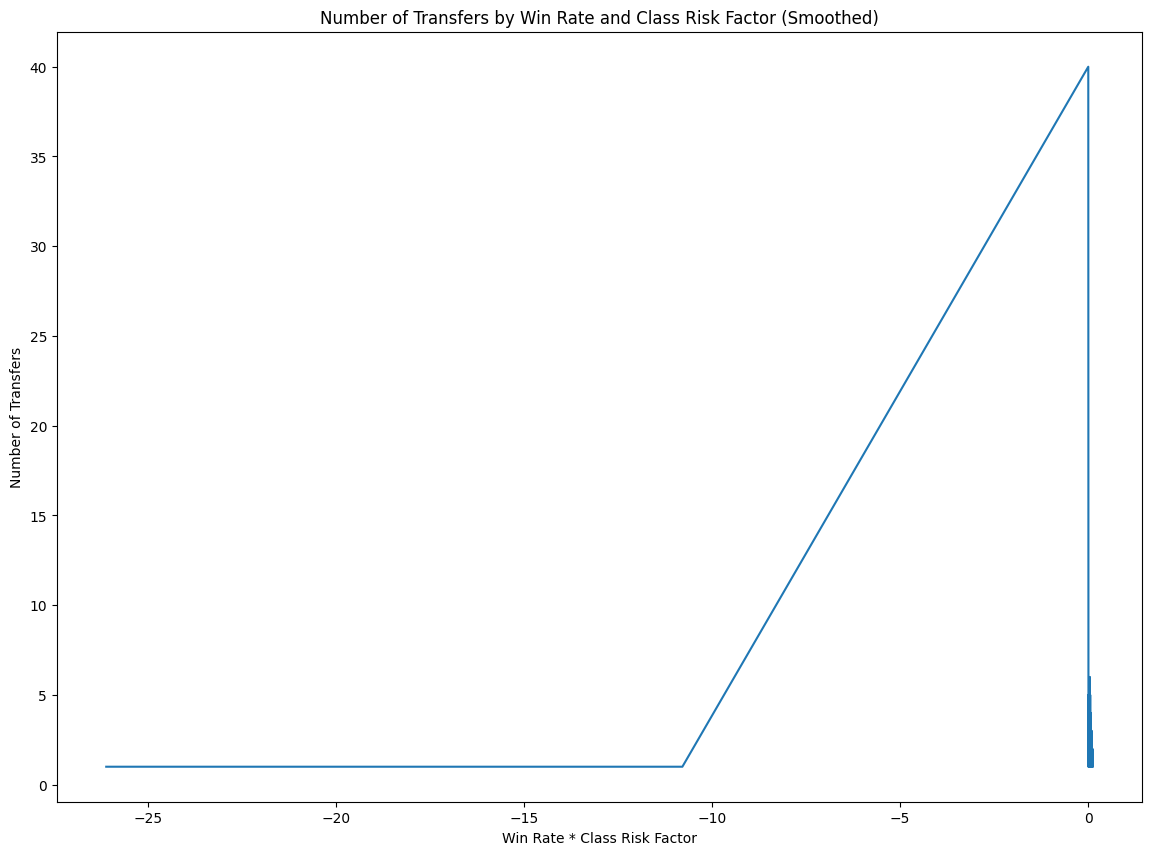

In [89]:
# Plot smoothed risk factor data
smoothed_risk_factor_data = risk_factor_data.copy()
smoothed_risk_factor_data['win_rate_class_risk_factor'] = smoothed_risk_factor_data['win_rate_class_risk_factor'].rolling(window=5).mean()
smoothed_risk_factor_data = smoothed_risk_factor_data.dropna()

plt.figure(figsize=(14, 10))
sns.lineplot(x='win_rate_class_risk_factor', y='win_rate_class_risk_factor', data=smoothed_risk_factor_data, estimator=lambda x: len(x), ci=None)
plt.title('Number of Transfers by Win Rate and Class Risk Factor (Smoothed)')
plt.xlabel('Win Rate * Class Risk Factor')
plt.ylabel('Number of Transfers')
plt.show()

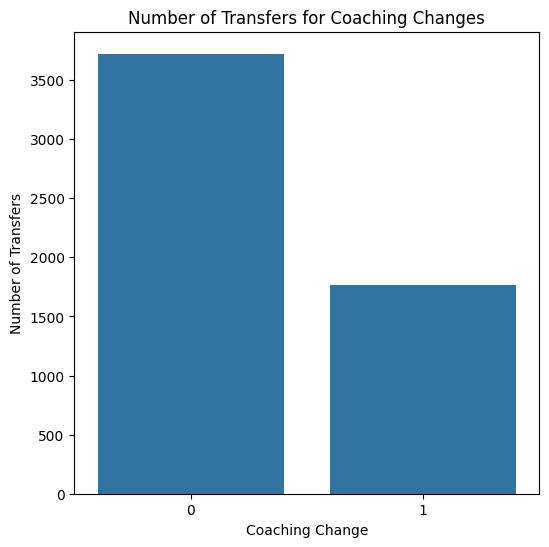

In [90]:
# Find if there is a coaching change for a player each year
team_coach_year = data_copy[['team', 'team_coach', 'season']].drop_duplicates()
team_coach_year = team_coach_year.sort_values(['team', 'season'])

coaching_changes = pd.DataFrame(columns=['team', 'season', 'team_coach', 'is_not_same_coach_next_season'])

for i in range(len(team_coach_year) - 1):
    current_row = team_coach_year.iloc[i]
    next_row = team_coach_year.iloc[i + 1]
    is_not_same_coach_next_season = current_row['team_coach'] != next_row['team_coach']
    coaching_changes = coaching_changes._append({
        'team': current_row['team'],
        'season': current_row['season'],
        'team_coach': current_row['team_coach'],
        'is_not_same_coach_next_season': is_not_same_coach_next_season
    }, ignore_index=True)

last_row = team_coach_year.iloc[-1]
coaching_changes = coaching_changes._append({
    'team': last_row['team'],
    'season': last_row['season'],
    'team_coach': last_row['team_coach'],
    'is_not_same_coach_next_season': True
}, ignore_index=True)

# Merge coaching_changes with data_copy
data_copy = pd.merge(data_copy, coaching_changes, on=['team', 'team_coach', 'season'], how='left')

#conver boolean to int
data_copy['is_not_same_coach_next_season'] = data_copy['is_not_same_coach_next_season'].astype(int)

coaching_changes_transfers = data_copy.groupby('is_not_same_coach_next_season').size().reset_index(name='transfer_count')

# Plot coaching changes
plt.figure(figsize=(6, 6))
sns.barplot(x='is_not_same_coach_next_season', y='transfer_count', data=coaching_changes_transfers)
plt.title('Number of Transfers for Coaching Changes')
plt.xlabel('Coaching Change')
plt.ylabel('Number of Transfers')
plt.show()

In [91]:
#engineer YoY featuers
#win rate, stats_passing_pct, usage_overall
#place 'yoy' in front of the new feature name

#sort data by player_playerId and season
data_copy = data_copy.sort_values(['player_playerId', 'season'])

#add YoY features
data_copy['yoy_win_rate'] = data_copy.groupby('player_playerId')['win_rate'].diff()
data_copy['yoy_stats_passing_pct'] = data_copy.groupby('player_playerId')['stats_passing_pct'].diff()
data_copy['yoy_usage_overall'] = data_copy.groupby('player_playerId')['usage_overall'].diff()

#fill NaN values with -999
data_copy['yoy_win_rate'] = data_copy['yoy_win_rate'].fillna(-999)
data_copy['yoy_stats_passing_pct'] = data_copy['yoy_stats_passing_pct'].fillna(-999)
data_copy['yoy_usage_overall'] = data_copy['yoy_usage_overall'].fillna(-999)

data_copy.head()

,transfer,season,player_playerId,player_firstName,player_lastName,player_position,player_teamId,team,player_height,player_weight,...,stats_fumbles_recovered,stats_fumbles_lost,win_rate,is_power_5,class_risk_factor,win_rate_class_risk_factor,is_not_same_coach_next_season,yoy_win_rate,yoy_stats_passing_pct,yoy_usage_overall
968,0,2016,-1044113,Chandler,Garrett,QB,2751,Wyoming,77.0,213.0,...,0.0,0.0,0.571429,0,0.0,0.0,0,-999.000000,-999.0,-999.0
3256,0,2016,-1043774,Karé,Lyles,QB,275,Wisconsin,72.0,212.0,...,0.0,0.0,0.785714,1,0.0,0.0,0,-999.000000,-999.0,-999.0
3257,0,2017,-1043774,Karé,Lyles,QB,275,Wisconsin,72.0,212.0,...,0.0,0.0,0.928571,1,0.0,0.0,0,0.142857,0.0,0.0
4074,0,2018,-1043761,Nate,Carter,QB,275,Wisconsin,77.0,200.0,...,0.0,0.0,0.615385,1,0.0,0.0,0,-999.000000,-999.0,-999.0
612,0,2016,-1043429,Brendan,Tabone,QB,2711,Western Michigan,72.0,195.0,...,0.0,0.0,0.928571,0,0.0,0.0,1,-999.000000,-999.0,-999.0


In [92]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Assuming your data is in a DataFrame called 'data'

# Drop specified columns
columns_to_drop = [
    "player_teamId", "usage_passingDowns", "usage_standardDowns", "usage_thirdDown",
    "usage_secondDown", "usage_firstDown", "usage_rush", "usage_pass",
    "stats_passing_attempts", "stats_passing_completions", "stats_passing_interceptions",
    "stats_rushing_ypc", "stats_rushing_touchdowns", "stats_rushing_carries",
    "stats_rushing_yards", "stats_rushing_long", "stats_fumbles_fumbles",
    "stats_fumbles_recovered", "stats_fumbles_lost",
    #EXPREIMENTAL
    "stats_passing_yards", "stats_passing_touchdowns"
]
data_copy = data_copy.drop(columns=columns_to_drop)

# Group by id_columns and aggregate
id_columns = ['player_playerId', 'season', 'team']
data_to_save = data_copy.groupby(id_columns, as_index=False).agg({
    col: 'first' for col in data_copy.columns if col not in id_columns
})

#Drop rows where player_class is greater than 10
data_to_save = data_to_save[data_to_save['player_class'] <= 10]

# Encode categorical variables
# Label Encoding for team_coach
le_coach = LabelEncoder()
data_to_save['team_coach_encoded'] = le_coach.fit_transform(data_to_save['team_coach'])
data_to_save['team_name_encoded'] = le_coach.fit_transform(data_to_save['team'])

# One-Hot Encoding for team_conference
ohe_conference = OneHotEncoder(sparse_output=False)
conference_encoded = ohe_conference.fit_transform(data_to_save[['team_conference']])
conference_columns = ohe_conference.get_feature_names_out(['team_conference'])

# Add encoded conference columns to the DataFrame
data_to_save = pd.concat([data_to_save, pd.DataFrame(conference_encoded, columns=conference_columns)], axis=1)

#if any cells apart of the conference columns are null replace with 0
data_to_save = data_to_save.fillna(0)

# Drop original text columns
data_to_save = data_to_save.drop(['team_coach', 'team_conference', 'team'], axis=1)


# Save the processed data
data_to_save.to_csv('../data/qbs_ml_ready.csv', index=False)

# Print columns
print(data_to_save.columns)



Index(['player_playerId', 'season', 'transfer', 'player_firstName',
       'player_lastName', 'player_position', 'player_height', 'player_weight',
       'player_class', 'usage_overall', 'stats_passing_pct', 'win_rate',
       'is_power_5', 'class_risk_factor', 'win_rate_class_risk_factor',
       'is_not_same_coach_next_season', 'yoy_win_rate',
       'yoy_stats_passing_pct', 'yoy_usage_overall', 'team_coach_encoded',
       'team_name_encoded', 'team_conference_ACC',
       'team_conference_American Athletic', 'team_conference_Big 12',
       'team_conference_Big Ten', 'team_conference_Conference USA',
       'team_conference_FBS Independents', 'team_conference_Mid-American',
       'team_conference_Mountain West', 'team_conference_Pac-12',
       'team_conference_SEC', 'team_conference_Sun Belt'],
      dtype='object')


C:\Users\aj132\AppData\Local\Temp\ipykernel_3116\3111723919.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_to_save = data_to_save.fillna(0)
